In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from matplotlib import pyplot
from prophet import Prophet
import datetime
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
import os

In [3]:
folder = "../decathlon/test_data_scientist/"

In [4]:
#load data as dataframe with Pandas
df_train = pd.read_csv(os.path.join(folder,"train.csv"))
df_test = pd.read_csv(os.path.join(folder,"test.csv"))
df_bu_feat = pd.read_csv(os.path.join(folder,"bu_feat.csv"))

In [3]:
#convert "day_id" columns into a datetime column 
df_train["day_id"] = pd.to_datetime(df_train["day_id"], format="%Y-%m-%d")
df_test["day_id"] = pd.to_datetime(df_test["day_id"], format="%Y-%m-%d")

#add features related to date : year and week
df_train["year"] = df_train["day_id"].dt.year
df_train["week"] = df_train["day_id"].dt.isocalendar().week

In [4]:
number_of_businessunit = len(list(df_train["but_num_business_unit"].unique()))
print("Number of business units :",number_of_businessunit)
number_of_department = len(list(df_train["dpt_num_department"].unique()))
print("Number of department :",number_of_department)

Number of business units : 322
Number of department : 4


To forecast the turnover at store-department level, to be as much precise as possible, a model should be built for each business_unit-department, meaning 322*4=1288 models.

It is too much. We need to find some ways to reduce this number.

In [5]:
df_train_grouped = df_train.groupby(["dpt_num_department","but_num_business_unit","year","week"]).sum().reset_index()
df_train_grouped = df_train_grouped[["turnover","dpt_num_department","but_num_business_unit","year","week"]]

# Idea :

Trying to group departments or business units together to reduce the number of models.

Study the representation of the turnover of the different business units if the global turnover along the time.
If it is the same, could permit to forecast the global turnover and use the percentages to derive the global 
turnover into business units turnover.

Study the representation of the turnover of the different departments from the global turnover of the business units.
If it is the same, could permit to use the year forecast of the business unit turnover to obtain the year turnover of a department.

Study the turnover of a department along the weeks from the year department turnover. Some seasonalities have been observed before.

# Proportion of the year turnover per business unit from the global year turnover

In [8]:
df_turnover_bu = df_train_grouped[["but_num_business_unit","turnover","year"]].copy()
df_turnover_bu = df_turnover_bu.groupby(["year","but_num_business_unit"]).sum()
#representation of the business turnover from the global turnover over years
df_turnover_bu_perc = df_turnover_bu.copy()
df_turnover_bu_perc["bu_percentage"] = df_turnover_bu_perc.groupby(level=0).apply(lambda x:x / float(x.sum()))
df_turnover_bu_perc = df_turnover_bu_perc.reset_index()
df_turnover_bu_perc.head(2)

,year,but_num_business_unit,turnover,bu_percentage
0,2012,1,1961.070225,0.002578
1,2012,2,1785.872047,0.002348


In [9]:
df_turnover_bu_perc_std = df_turnover_bu_perc[["but_num_business_unit","bu_percentage"]].groupby(["but_num_business_unit"]).std()
df_turnover_bu_perc_std.rename(columns={'bu_percentage':'std_percentage'},inplace=True)
df_turnover_bu_perc_std = df_turnover_bu_perc_std.reset_index()

In [10]:
# for some business unit, we have NaN std. 
bu_nan = list(df_turnover_bu_perc_std[df_turnover_bu_perc_std["std_percentage"].isnull()]["but_num_business_unit"])
df_t = df_turnover_bu.reset_index()
df_t[df_t["but_num_business_unit"].isin(bu_nan)].head()

,year,but_num_business_unit,turnover
1698,2017,1607,20346.650194
1699,2017,1608,38103.403663
1700,2017,1609,32661.870513
1702,2017,1616,16496.640736
1704,2017,1869,17728.523360


The nan std comes from business units that exist only since 2017.

<AxesSubplot:xlabel='but_num_business_unit', ylabel='std_percentage'>

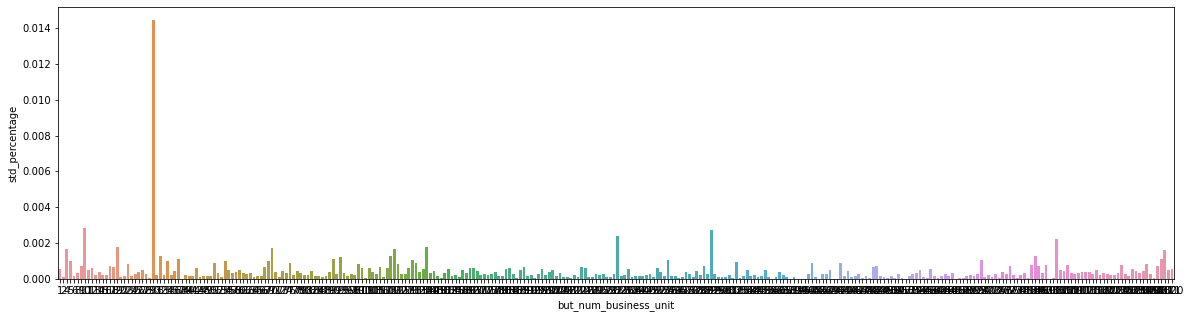

In [11]:
df_ = df_turnover_bu_perc_std[df_turnover_bu_perc_std["std_percentage"].notnull()]
fig, ax = pyplot.subplots(figsize=(20,5))
sns.barplot(ax=ax,data=df_,x="but_num_business_unit",y="std_percentage")

In [12]:
df_turnover_bu_perc_std[df_turnover_bu_perc_std["std_percentage"]>0.2]
print(2*df_turnover_bu_perc_std["std_percentage"].max())

0.02889263561622695


Along the time, the percentage of the turnover made by a business unit compared to the global turnover vary of 3% maximum (2*std). It can be admit that the prediction of the business unit turnover can be calculated from the prediction of the turnover of all the business units by applying a representation percentage of the business unit.

In [13]:
#pourcentages à appliquer
df_mean_turnover_bu_perc = df_turnover_bu_perc.groupby("but_num_business_unit").mean().reset_index()
df_mean_turnover_bu_perc = df_mean_turnover_bu_perc[["but_num_business_unit","bu_percentage"]]
df_mean_turnover_bu_perc.head()

,but_num_business_unit,bu_percentage
0,1,0.002654
1,2,0.002561
2,4,0.007136
3,5,0.008336
4,6,0.003924


# Proportion of departments per business units

In [14]:
df_sport_magasin_year = df_train_grouped[["but_num_business_unit","dpt_num_department","turnover"]].copy()
df_sport_magasin_year = df_sport_magasin_year.groupby(["but_num_business_unit","dpt_num_department"]).sum()
df_sport_magasin_year["percentage"] = df_sport_magasin_year.groupby(level=0).apply(lambda x:x / float(x.sum()))
df_sport_magasin_year_filt = df_sport_magasin_year.reset_index()
df_sport_magasin_year_filt = df_sport_magasin_year_filt[df_sport_magasin_year_filt["percentage"].isnull()!=True]

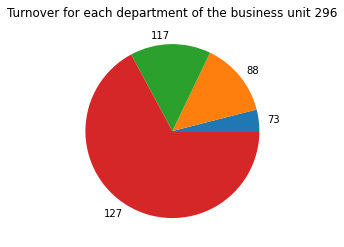

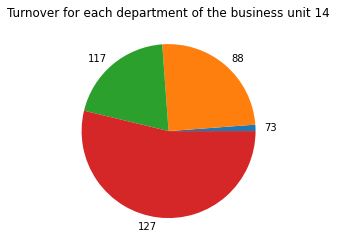

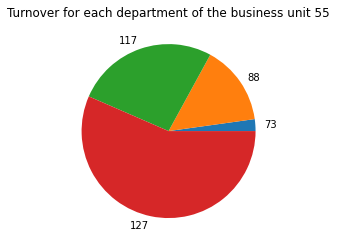

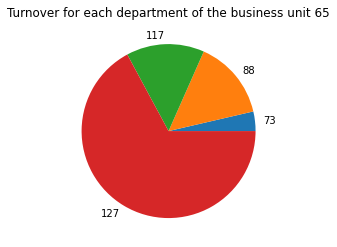

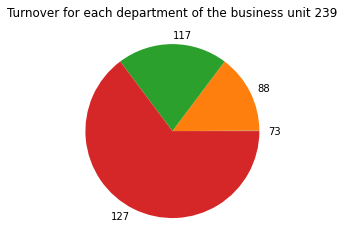

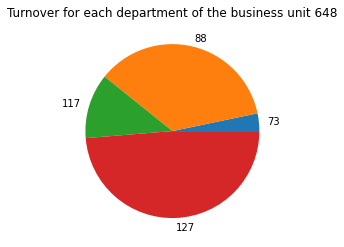

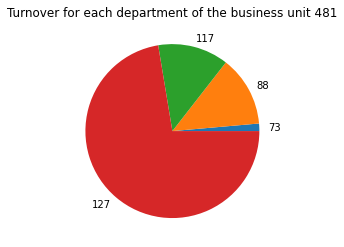

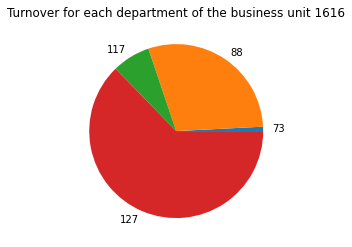

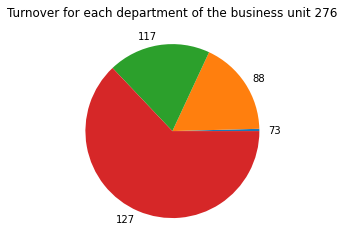

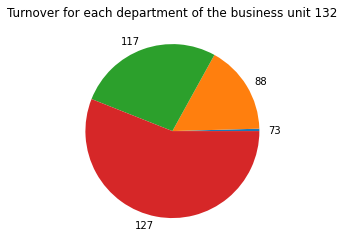

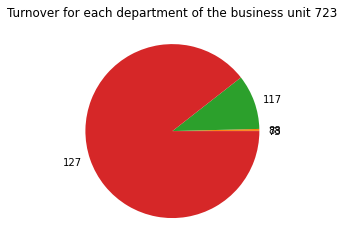

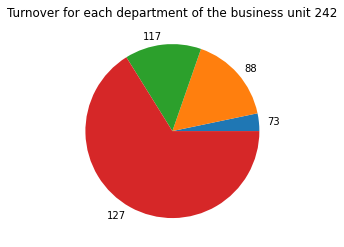

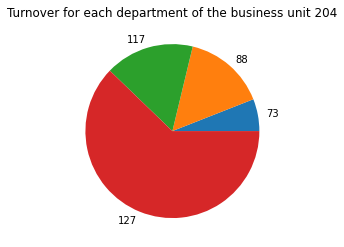

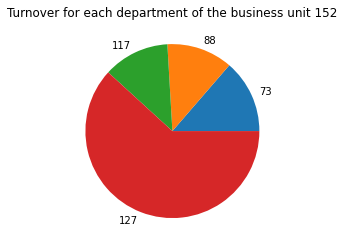

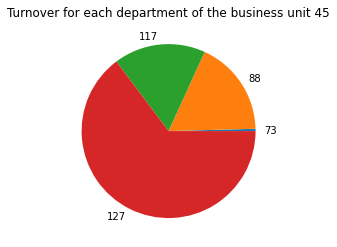

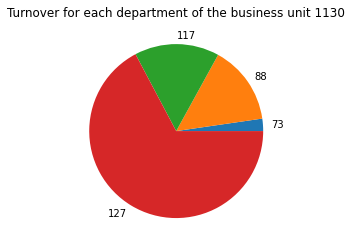

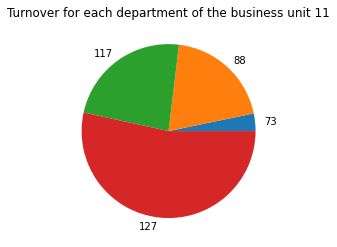

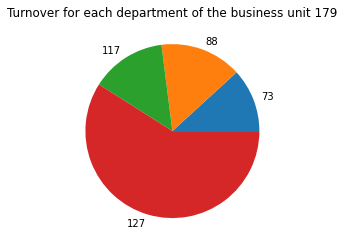

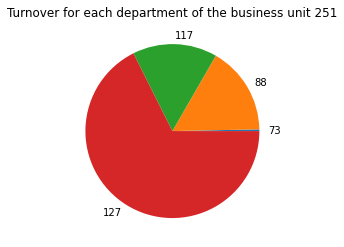

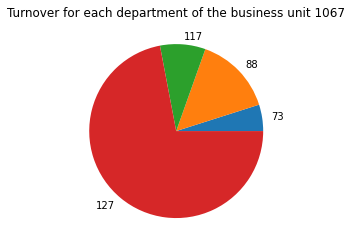

In [15]:
random_business_unit = random.sample(list(df_sport_magasin_year_filt["but_num_business_unit"].unique()),20)
for i, bu in enumerate(random_business_unit):
    filt_bu = (df_sport_magasin_year_filt["but_num_business_unit"]==bu)
    df_filt_plot = df_sport_magasin_year_filt[filt_bu]
    plt.figure(i)
    plt.title(f"Turnover for each department of the business unit {bu}")
    plt.pie(df_filt_plot['percentage'],labels=df_filt_plot['dpt_num_department'])

From the plot above, we can conclude that for all the business unit, the sport representation of each department in the yearly turnover of the business units is similar.
It means that the forecast of the global turnover can be made and then the percentage of representation of each department will be applied.

For more precision, could be better to use regions.

In [16]:
# find the percentage of each department
repres_department = list()
department = list()
for dep in list(df_sport_magasin_year_filt["dpt_num_department"].unique()):
    filt_dep = df_sport_magasin_year_filt["dpt_num_department"]==dep
    df_dep = df_sport_magasin_year_filt[filt_dep]
    mean_val = df_dep["percentage"].mean()
    department.append(dep)
    repres_department.append(mean_val)
    print(f'Department {dep} : percentage representation mean : {mean_val}')
df_department_repres = pd.DataFrame(list(zip(department, repres_department)),columns =["dpt_num_department", "department_percentage"])

Department 73 : percentage representation mean : 0.037590141749647026
Department 88 : percentage representation mean : 0.1728018109708206
Department 117 : percentage representation mean : 0.17044835775376
Department 127 : percentage representation mean : 0.6281820284038313


# Analysis of the turnover for the different departments along the time

In [17]:
df_turn_dep = df_train[["day_id","dpt_num_department","turnover","week"]].copy()

<Figure size 432x288 with 0 Axes>

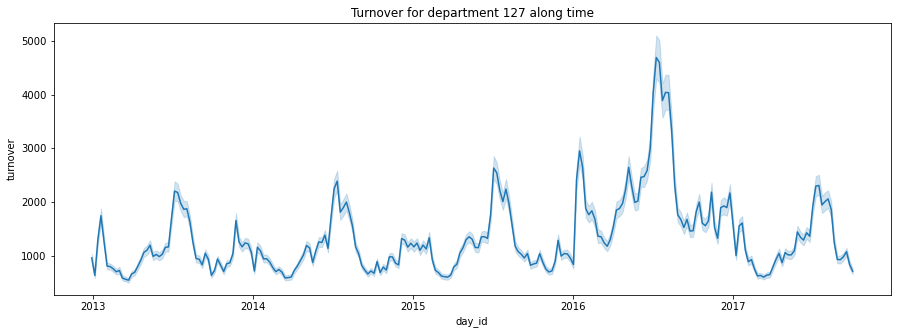

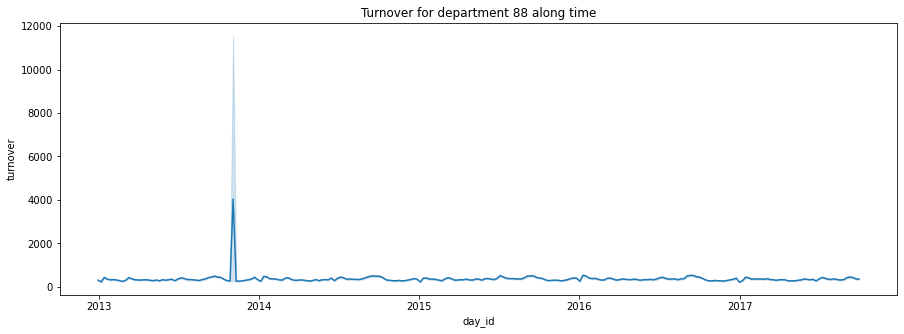

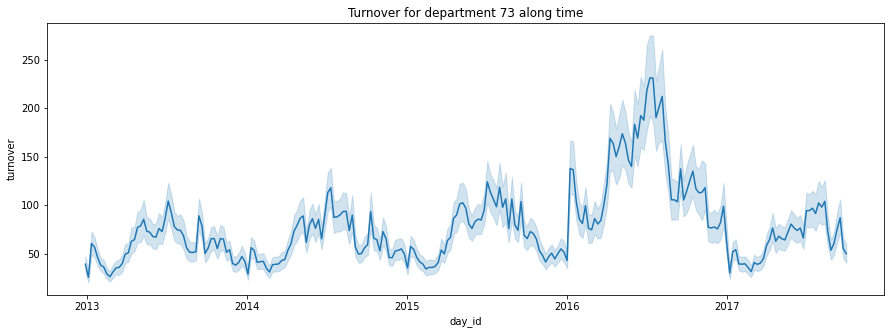

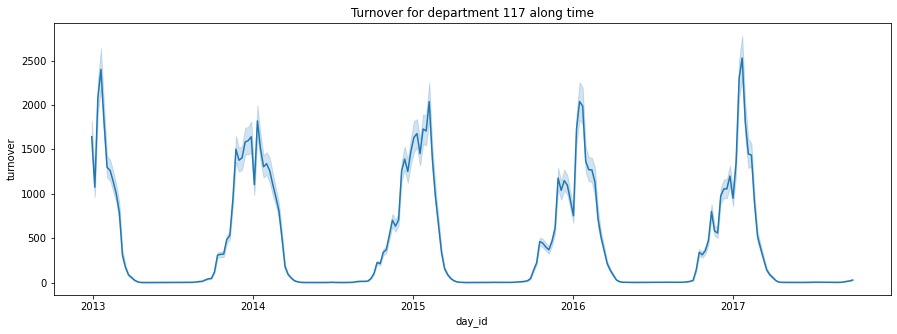

In [18]:
for i, dep in enumerate(list(df_turn_dep["dpt_num_department"].unique())):
    df_turn_dep_filt = df_turn_dep[(df_turn_dep["dpt_num_department"]==dep)]
    plt.figure(i)
    fig, ax = pyplot.subplots(figsize=(15,5))
    plt.title(f"Turnover for department {dep} along time")
    sns.lineplot(ax=ax,data=df_turn_dep_filt, x='day_id', y='turnover',palette="tab10")

From these plots, we can definitely seen some beautiful seasonalities with proportional values. 
It means that we can consider that the percentage of the turnover of the departments at a certain week can be use along time.

In [19]:
#percentage turnover by department by week
df_turn_dep_gr = df_turn_dep.groupby(["dpt_num_department","week"]).sum()
df_turn_dep_gr["week_percentage"] = df_turn_dep_gr.groupby(level=0).apply(lambda x:x / float(x.sum()))

In [20]:
df_perc_dep_week = df_turn_dep_gr.reset_index()[["dpt_num_department","week","week_percentage"]]
df_perc_dep_week.head()

,dpt_num_department,week,week_percentage
0,73,1,0.012898
1,73,2,0.018105
2,73,3,0.016148
3,73,4,0.012914
4,73,5,0.012113


# Global turnover forecast

In [21]:
df_forecast_turnover = df_train[["day_id","turnover"]]
df_forecast_turnover = df_forecast_turnover.groupby("day_id").sum().reset_index()
df_forecast_turnover.head(2)

,day_id,turnover
0,2012-12-29,760549.928211
1,2013-01-05,506344.523372


<AxesSubplot:title={'center':'Turnover along time'}, xlabel='day_id', ylabel='turnover'>

<Figure size 432x288 with 0 Axes>

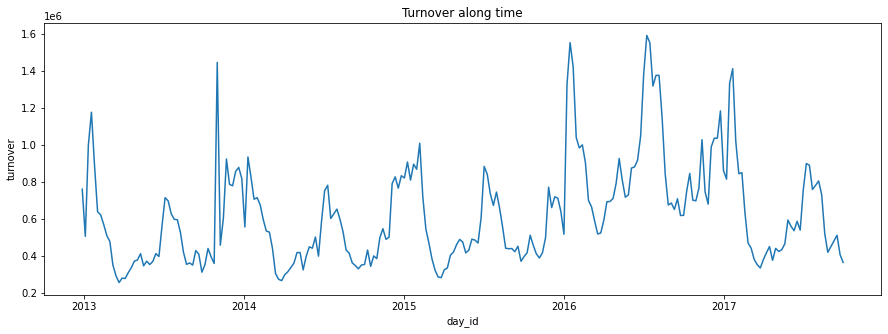

In [22]:
plt.figure(i)
fig, ax = pyplot.subplots(figsize=(15,5))
plt.title(f"Turnover along time")
sns.lineplot(ax=ax,data=df_forecast_turnover, x='day_id', y='turnover',palette="tab10")

In [23]:
#train test split
# Define threshold date = we are going to forecast the last 2 months of train dataset : august and september 2017 -> 62 days
threshold_date = df_forecast_turnover["day_id"].max() - datetime.timedelta(days=62)
df_forecast_turnover = df_forecast_turnover.rename(columns={"day_id":"ds","turnover":"y"})
mask = df_forecast_turnover['ds'] < threshold_date
# Split the data and select `ds` and `y` columns.
df_train_fc = df_forecast_turnover[mask][['ds', 'y']]
df_test_fc= df_forecast_turnover[~ mask][['ds', 'y']]

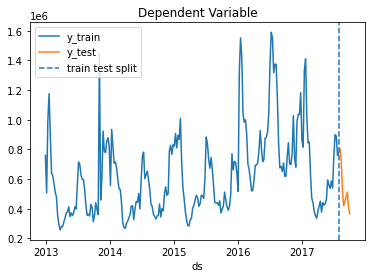

In [24]:
fig, ax = plt.subplots()
sns.lineplot(x='ds', y='y', label='y_train', data=df_train_fc, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test_fc, ax=ax)
ax.axvline(threshold_date, linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

In [25]:
m = Prophet(yearly_seasonality=True,weekly_seasonality=False,daily_seasonality=False)
m.fit(df_train_fc)

In [26]:
future = m.make_future_dataframe(periods=df_test_fc.shape[0], freq='W')
forecast = m.predict(df=future)

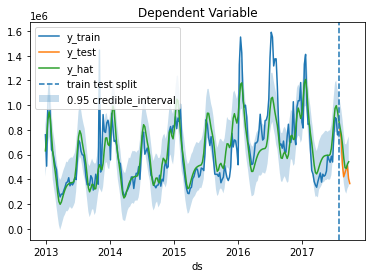

In [27]:
mask2 = forecast['ds'] < threshold_date

forecast_train = forecast[mask2]
forecast_test = forecast[~ mask2]
fig, ax = plt.subplots()

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df_train_fc, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test_fc, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)
ax.axvline(threshold_date, linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

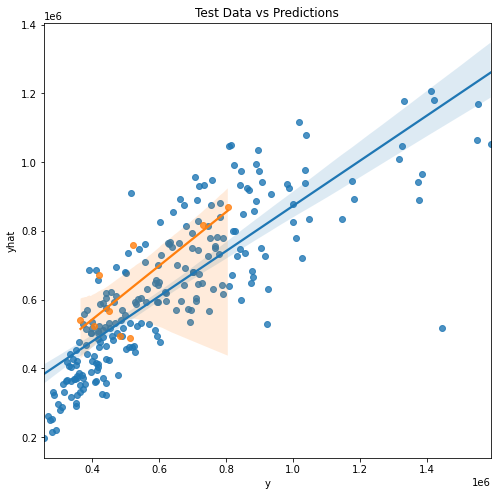

In [29]:
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=df_train_fc['y'], y=forecast_train['yhat'],label='train', ax=ax)
sns.regplot(x=df_test_fc['y'], y=forecast_test['yhat'], label='test', ax=ax)
ax.set(title='Test Data vs Predictions');

In [51]:
r2_train = r2_score(y_true=df_train_fc['y'], y_pred=forecast_train['yhat'])
r2_test = r2_score(y_true=df_test_fc['y'], y_pred=forecast_test['yhat'])
mae_train = mean_absolute_error(y_true=df_train_fc['y'], y_pred=forecast_train['yhat'])
mae_test = mean_absolute_error(y_true=df_test_fc['y'], y_pred=forecast_test['yhat'])

print('r2 train: {}'.format(r2_train))
print('r2 test: {}'.format(r2_test))
print('---')
print('mae train: {}'.format(mae_train))
print('mae test: {}'.format(mae_test))

r2 train: 0.6842241224861625
r2 test: -0.06914066020989806
---
mae train: 110421.68315068693
mae test: 120849.6429990961


In [55]:
df_month = df_train.copy()
df_month["month"] = df_month["day_id"].dt.month
df_month = df_month[(df_month["year"]==2017) & (df_month["month"].isin([8,9]))]
print("It represents a percentage of error of turnover for the two months predicted of :",mae_test/df_month["turnover"].sum())

It represents a percentage of error of turnover for the two months predicted of : 0.025733886746108253


The Mean Absolute Error is interesting for us because it represents the mean absolute difference between the prediction and the real value, in our case the predicted turnover and the real turnover.

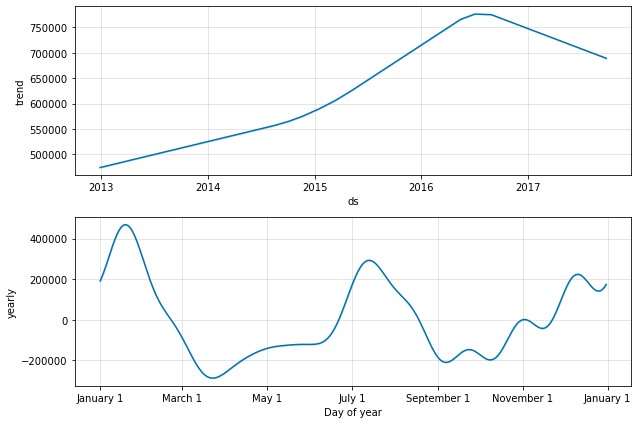

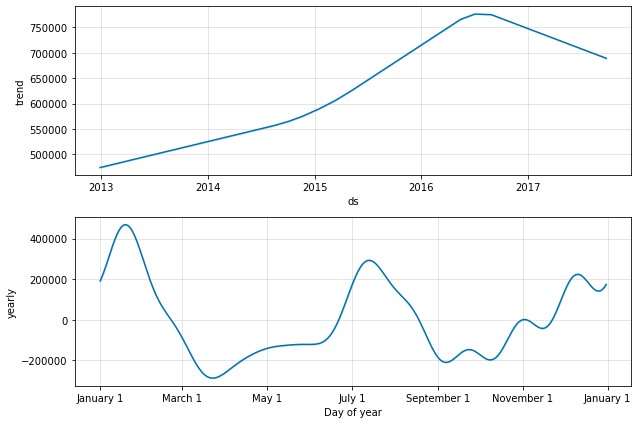

In [31]:
m.plot_components(forecast)

# Predict on test dataset

In [32]:
future_test = pd.DataFrame({'ds': list(df_test["day_id"].unique())})
prediction_test = m.predict(future_test)

In [33]:
df_test_pred = prediction_test[["ds","yhat"]]

In [34]:
#calcul de la semaine
df_test_pred.loc[:,"week"] = df_test_pred["ds"].dt.isocalendar().week

/home/louis/miniconda3/envs/dev/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/louis/miniconda3/envs/dev/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [35]:
#find date 1 year ago
date_one_year = df_test_pred["ds"].max() - datetime.timedelta(days=365)
date_one_year

Timestamp('2016-11-25 00:00:00')

In [36]:
#filt train data to obtain one year
filt_date = df_train["day_id"] >= date_one_year
turnover_train_part = df_train[filt_date]["turnover"].sum()
turnover_test_part = df_test_pred["yhat"].sum()

In [37]:
#calculate turnover for the one year (rolling)
turnover_rolling_year = turnover_train_part+turnover_test_part
print(turnover_rolling_year)

34595531.06909541


In [38]:
#apply percentage for each business unit to obtain turnover per business unit on the year
df_result = df_mean_turnover_bu_perc.copy()
df_result["turnover_bu"] = df_result["bu_percentage"]*turnover_rolling_year

In [39]:
#apply percentage for each department to obtain turnover per department per business unit
cols = list(df_department_repres.columns)
df_department_repres_all = pd.DataFrame(columns=cols)
df_department_repres_all = df_department_repres_all.append([df_department_repres]*322,ignore_index=True)

cols = list(df_result.columns)
df_result_1 = pd.DataFrame(columns=cols)
df_result_1 = df_result_1.append([df_result]*4,ignore_index=True)
df_result_1.sort_values(by="but_num_business_unit",inplace=True)
df_result_1 = df_result_1.reset_index(drop=True)

df_turnover_businessunit = pd.concat([df_result_1,df_department_repres_all],axis=1)

#apply percentage of department
df_turnover_businessunit.loc[:,"turnover_bu_dep"] = df_turnover_businessunit["turnover_bu"]*df_turnover_businessunit["department_percentage"]
df_turnover_businessunit = df_turnover_businessunit[["but_num_business_unit","dpt_num_department","turnover_bu_dep"]]

In [40]:
#apply percentage from department on the week to have final turnover
df_perc_dep_week_filt = df_perc_dep_week[df_perc_dep_week["week"].isin(list(df_test_pred["week"]))]
df_perc_dep_week_filt = df_perc_dep_week_filt.reset_index(drop=True)
df_turnover_department_week = pd.merge(df_turnover_businessunit, df_perc_dep_week_filt, on="dpt_num_department", how="outer")
df_turnover_department_week["turnover_pred"] = df_turnover_department_week["turnover_bu_dep"]*df_turnover_department_week["week_percentage"]

In [41]:
#prepare types for merging with test dataset
df_turnover_department_week = df_turnover_department_week[["but_num_business_unit","dpt_num_department","week","turnover_pred"]]
df_turnover_department_week["dpt_num_department"] = df_turnover_department_week["dpt_num_department"].astype("int")
df_turnover_department_week["but_num_business_unit"] = df_turnover_department_week["but_num_business_unit"].astype("int")

df_test["week"] = df_test["day_id"].dt.isocalendar().week

#final prediction
df_result_final = df_test.merge(df_turnover_department_week,on=["but_num_business_unit","dpt_num_department","week"],how="left")
df_result_final.head(2)

,day_id,but_num_business_unit,dpt_num_department,week,turnover_pred
0,2017-11-25,95,73,47,85.133867
1,2017-11-25,4,117,47,1284.266306
